<a href="https://colab.research.google.com/github/Virosax/SRP/blob/main/Social_Circles_Facebook_Bilag_d0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.2/110.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.4 MB/s eta 0:00:00
Netværk: 4039 knuder, 88234 kanter

Startknuder:
- Højest grad: 107 (grad: 1045)
- Højest egenvektor: 1912 (værdi: 0.0954)
- Knude 853: (grad: 44)
- Knude 1684: (grad: 792)
- Knude 2347: (grad: 291)

Kører simuleringer...

Beregnet R₀:
- Høj grad: 1.45
- Høj egenvektor: 1.43
- Knude 853: 1.08
- Knude 1684: 1.42
- Knude 2347: 1.43


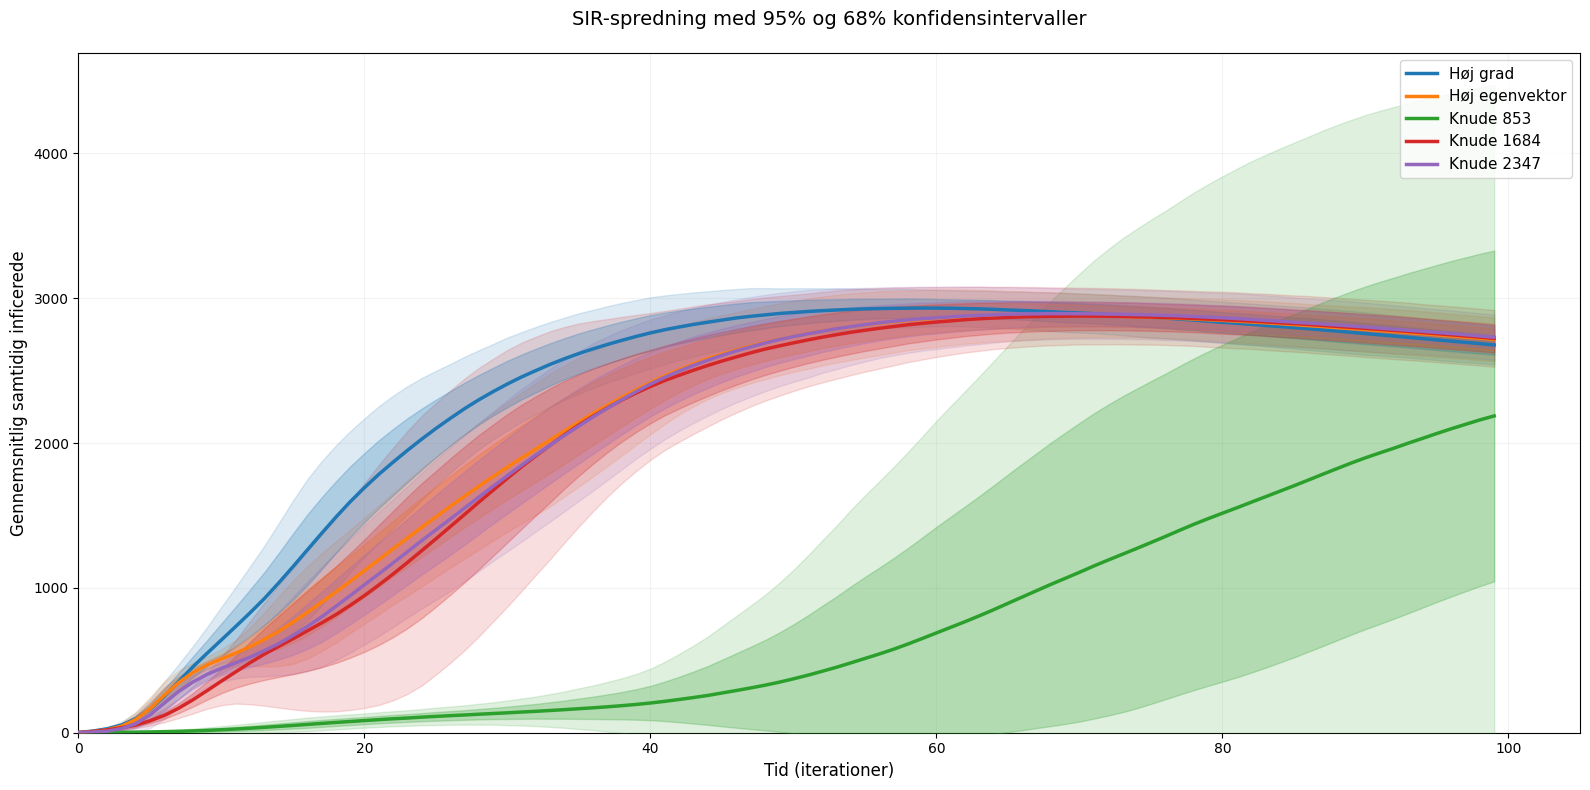

In [1]:
# ======================
# 0. Importer biblioteker og indlæs data
# ======================
!pip install ndlib networkx matplotlib pandas numpy
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from ndlib.models.epidemics import SIRModel
from ndlib.models.ModelConfig import Configuration
from networkx.algorithms.centrality import eigenvector_centrality

# Indlæs Facebook-netværk
url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
df = pd.read_csv(url, sep=" ", header=None, names=["source", "target"], comment="#")
G = nx.from_pandas_edgelist(df)
print(f"Netværk: {G.number_of_nodes()} knuder, {G.number_of_edges()} kanter")

# ======================
# 1. Find startknuder
# ======================
# Gradcentralitet
grad_centralitet = dict(G.degree())
top_grad_node = max(grad_centralitet, key=grad_centralitet.get)

# Egenvektorcentralitet
try:
    eigen_centralitet = eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    eigen_centralitet = eigenvector_centrality(G, max_iter=1000, tol=1e-3)
top_eigen_node = max(eigen_centralitet, key=eigen_centralitet.get)

# Valgte knuder
valgte_knuder = [853, 1684, 2347]
for knude in valgte_knuder:
    if knude not in G.nodes():
        print(f"Advarsel: Knude {knude} findes ikke i netværket")
        valgte_knuder.remove(knude)

print("\nStartknuder:")
print(f"- Højest grad: {top_grad_node} (grad: {grad_centralitet[top_grad_node]})")
print(f"- Højest egenvektor: {top_eigen_node} (værdi: {eigen_centralitet[top_eigen_node]:.4f})")
for knude in valgte_knuder:
    print(f"- Knude {knude}: (grad: {grad_centralitet[knude]})")

# ======================
# 2. Simuleringsfunktion
# ======================
def run_multiple_sir_simulations(start_node, num_simulations=100, a=0.01, b=0.005, iterations=100):
    all_simulations = []
    for _ in range(num_simulations):
        model = SIRModel(G)
        config = Configuration()
        config.add_model_parameter('beta', a)
        config.add_model_parameter('gamma', b)
        config.add_model_initial_configuration("Infected", [start_node])
        model.set_initial_status(config)
        iterations_result = model.iteration_bunch(iterations)
        all_simulations.append([it['node_count'][1] for it in iterations_result])
    return np.mean(all_simulations, axis=0), np.std(all_simulations, axis=0)

# ======================
# 3. Kør simuleringer
# ======================
print("\nKører simuleringer...")
sim_results = {
    'Høj grad': run_multiple_sir_simulations(top_grad_node),
    'Høj egenvektor': run_multiple_sir_simulations(top_eigen_node)
}
for knude in valgte_knuder:
    sim_results[f'Knude {knude}'] = run_multiple_sir_simulations(knude)

# ======================
# 4. Beregn R₀ (men vis ikke i plot)
# ======================
def calculate_R0(avg_infected, a, b, total_nodes):
    """Beregner R₀ baseret på gennemsnitlig maksimal smitte"""
    max_infected_avg = np.max(avg_infected)
    return (max_infected_avg / total_nodes) * (a / b)

a = 0.01  # Infektionsrate
b = 0.005 # Helbredelsesrate
total_nodes = G.number_of_nodes()

print("\nBeregnet R₀:")
for label, (avg, std) in sim_results.items():
    R0 = calculate_R0(avg, a, b, total_nodes)
    print(f"- {label}: {R0:.2f}")

# ======================
# 5. Visualisering (uden R₀ i grafen)
# ======================
plt.figure(figsize=(16, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
tid = np.arange(100)

for idx, ((label, (avg, std)), color) in enumerate(zip(sim_results.items(), colors)):
    # Hovedkurve
    plt.plot(tid, avg, label=label, color=color, lw=2.5, zorder=10)

    # Konfidensintervaller
    plt.fill_between(tid,
                    avg - 2*std,
                    avg + 2*std,
                    color=color, alpha=0.15, zorder=5)

    plt.fill_between(tid,
                    avg - std,
                    avg + std,
                    color=color, alpha=0.25, zorder=6)

plt.title('SIR-spredning med 95% og 68% konfidensintervaller', fontsize=14, pad=20)
plt.xlabel('Tid (iterationer)', fontsize=12)
plt.ylabel('Gennemsnitlig samtidig inficerede', fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.15)
plt.xlim(0, 105)
plt.ylim(0, np.max([avg + 2*std for avg, std in sim_results.values()]) * 1.05)
plt.tight_layout()
plt.show()